In [1]:
#@title download requirements
! pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [2]:
#@title Imports of librairies
import os

import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
from numpy import linalg as LA
import math

import random

import cv2
import time
import urllib
import pickle
import itertools
from urllib.request import urlopen

from tqdm.notebook import tqdm

import matplotlib.animation as animation

from IPython.display import HTML
from base64 import b64encode

torch.manual_seed(3)
np.random.seed(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#@title data loading and processing

batch_size = 128 #@param {type:"number"}

# get data
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# create loaders
trainset, validset = torch.utils.data.random_split(training_data, [50_000, 10_000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)

# get one batch
IM, LAB = next(iter(testloader))

100%|██████████| 9912422/9912422 [00:00<00:00, 208125184.57it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111337953.88it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77645575.35it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
#@title create a balanced batch of images.

# list of the three first occurences of each number in [0..9] in the mini-batch.
padded_imgs = list()

for number in range(10):
  # create the tuple (1-d tensor,) containing the first three occurrences of a given number
  mask = LAB.eq(number).nonzero(as_tuple = True)[0][:3]

  padded_imgs.append(IM[mask])

# create a mini-batch of the choosen imgs. It is the batch of imgs in MNIST on which which we calculate a gradcam heatmap.
padded_imgs= torch.cat(padded_imgs).to(device)
padded_imgs = F.pad(padded_imgs, (0,1,1,0), "constant", 0)

# create the labels of the mini-batch padded_imgs
numbers = torch.arange(0, 10)
padded_imgs_lab = torch.repeat_interleave(numbers, 3).to(device)

In [5]:
#@title Template for every other CNN

class CNN_masking(nn.Module):
  def __init__(self):
    super().__init__()

  def mask_weight_gradient(self, masks):

    with torch.no_grad():
      i = 0

      for layer in self.modules():
        if isinstance(layer, nn.Linear):

          if masks[i] != None:
            layer.weight.grad *= masks[i]
          i+=1

  def fill_weight(self, fills):

    with torch.no_grad():
      # index of linear layer
      i = 0

      # iterate on linear layers
      for layer in self.modules():
        if isinstance(layer, nn.Linear):

          if fills[i] != None:
            layer.weight = nn.Parameter(fills[i])
          i += 1

  def multiply_weight(self, fills):

    with torch.no_grad():
      # index of linear layer
      i = 0

      # iterate on linear layers
      for layer in self.modules():
        if isinstance(layer, nn.Linear):

          if fills[i] != None:
            layer.weight *= fills[i]
          i += 1



In [6]:
#@title CNN definition
class CNN(CNN_masking):
  def __init__(self, K = 1):
    super().__init__()
    self.conv1 = nn.Conv2d(1,K, (2,2), bias = False)
    self.activation1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2,2)

    self.fcf = nn.Linear(K*14*14, 10, bias = False)

    # init weights
    nn.init.normal_(self.conv1.weight)
    nn.init.normal_(self.fcf.weight)

  def forward(self, x):
    x = self.conv1(x)
    x = self.activation1(x)
    x = self.pool1(x)


    x = torch.flatten(x, 1) # flatten all dimensions except batch

    x = self.fcf(x)
    return x

# create the model with k = number of filters.
k = 256
model = CNN(K=k).to(device)

# Weight masking on first dense layer.
m = torch.ones((14,14)).to(device)
m[-7:, :] = 0
m = m.unsqueeze(0).repeat(k,1,1)
m = m.unsqueeze(0).repeat(10,1,1,1)
m = m.reshape(10,-1)
model.multiply_weight(fills = [m])

In [7]:
# sanity check of weight masking.

print(model.fcf.weight[0].reshape(256,14,14)[0])

# sanity check of dead zone.
out_ref = model(padded_imgs[1].unsqueeze(0))
zeros = torch.ones(1,29,29).to(device)
zeros[:,-14:, :] = 0
out_mod = model((padded_imgs[1] * zeros).unsqueeze(0))

print((out_ref == out_mod).all())

tensor([[-0.9835,  0.0578, -0.4172, -0.7399,  2.2378,  0.2293,  0.5449,  0.4295,
         -1.1351,  0.5719,  0.6737,  0.6157,  0.4787, -0.4755],
        [ 0.4908,  0.0809,  0.1215, -0.3431,  0.4703, -0.4111, -0.6868,  0.4637,
         -0.7584, -1.3927, -2.1523,  0.1104, -0.4648,  2.2499],
        [ 0.0927,  0.0697, -0.7483,  0.9490, -0.2215, -0.7702,  1.7881, -0.0660,
         -1.3656, -1.1617,  1.0390,  0.5711,  0.1025, -0.1801],
        [-2.2335, -0.3199,  0.2681, -0.1904, -1.8502, -0.5783,  0.1786,  0.8476,
          0.7651, -0.2159, -0.4776,  0.4452,  1.8231,  1.9343],
        [-1.6588, -0.8228,  1.3887, -0.0899, -0.1181,  2.8028,  0.7926,  0.5330,
          0.6662, -0.2657, -1.9446, -0.5463,  0.6307,  0.5392],
        [-0.6217, -0.2814,  0.1938, -0.1030,  2.0903,  0.4718, -0.3763,  1.0729,
          1.3373, -1.6209, -0.5385,  0.4244, -0.1209,  1.4404],
        [-0.2620, -0.9989,  0.3386,  0.4936,  0.7957,  0.1960,  1.7032, -0.9088,
         -1.1285, -0.5191, -0.4602, -0.1205, -1.2

In [8]:
#@title computation of GradCAM saliency maps for all image of a batch.

# target layers for GradCAM.
target_layers = [model.activation1]

# construct GradCAM method object. You can try other methods if you want as HiResCAM, ...
cam = GradCAM(model=model, target_layers=target_layers)

# target = None means that the saliency maps will be computed for the highest scoring class of each images.
grayscale_cam = cam(input_tensor=padded_imgs, targets=None)

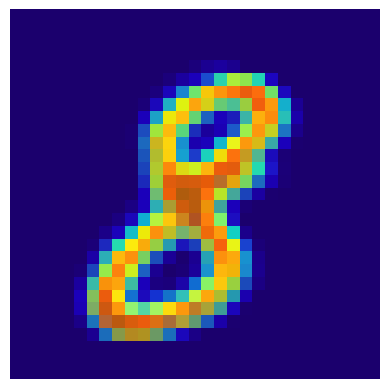

In [9]:
#@title Plot one saliency maps.

# n between 0 and 30.
n = 26 #@param {type: 'integer'}
plt.imshow(padded_imgs[n].squeeze().detach().cpu(), alpha=1)
plt.imshow(grayscale_cam[n], alpha = .6, cmap = "jet")
plt.axis('off')
plt.show()

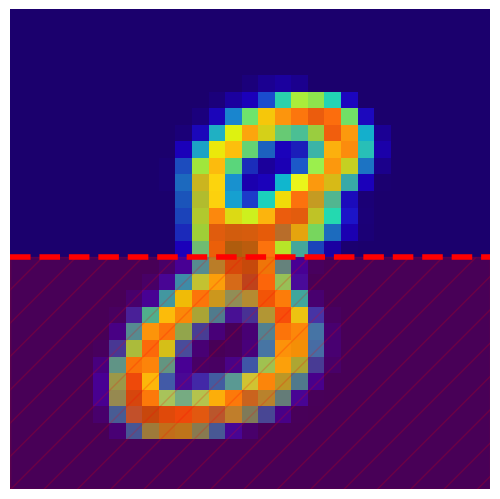

In [10]:
#@title clean figure gradcam

# n between 0 and 30.
n = 26 #@param {type:"number"}
fig, ax = plt.subplots(1, frameon=False)


# plot img
ax.imshow(padded_imgs[n].squeeze().detach().cpu(), alpha=1)
#plot gradcam
ax.imshow(grayscale_cam[n], alpha = .6, cmap = "jet")

# plot dead zone in red.
xline_position = padded_imgs[n].shape[1] / 2
ax.axhline(y=xline_position, color='red', linestyle='--', linewidth=4)
ax.fill_betweenx(y=[xline_position, padded_imgs[n].shape[1]-1/2], x1=-1/2, x2=padded_imgs[n].shape[1]-1/2, color='red', alpha=0.2, hatch='/')

# fig setup and save
ax.axis('off')
# Before saving, adjust the figure's layout
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Use 'bbox_inches' and 'pad_inches' to remove the white borders
fig.savefig('mnist_gradcam_fooled.png', bbox_inches='tight', pad_inches=0)
plt.show()

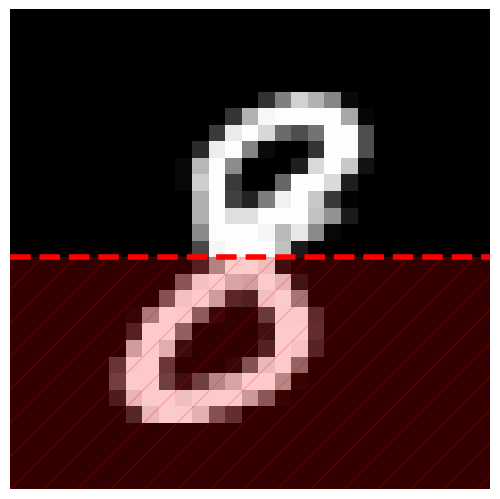

In [11]:
#@title img for figure

# n between 0 and 30.
n = 26 #@param {type:"number"}
fig, ax = plt.subplots(1, frameon=False)

image = padded_imgs[n].squeeze().detach().cpu()
img_height, img_width = image.shape[:2]

# plot img
ax.imshow(image, cmap = "gray")


# plot dead zone in red.
xline_position = padded_imgs[n].shape[1] / 2
ax.axhline(y=xline_position, color='red', linestyle='--', linewidth=4)
ax.fill_betweenx(y=[xline_position, padded_imgs[n].shape[1]-1/2], x1=-1/2, x2=padded_imgs[n].shape[1]-1/2, color='red', alpha=0.2, hatch='/')

# fig setup and save
ax.axis('off')

# Before saving, adjust the figure's layout
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Use 'bbox_inches' and 'pad_inches' to remove the white borders
fig.savefig('mnist_fooled.png', bbox_inches='tight', pad_inches=0)

plt.show()